## Importing Libraries


In [61]:
## Importing libraries 
import pandas as pd 
import numpy as np
import re
import nltk
import spacy
import gensim
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from contraction import CONTRACTION_MAP

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.initializers import Constant

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Understanding the data

In [62]:
## Load data set 
headlines = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)

## Size of the data 
print(f"Size of the data :- {headlines.shape}\n")

## How data looks like 
print(f"Sample Data :- \n{headlines.head(5)}\n")

## checking is there any null values present in the dataset or not 
print(f"Checking null values :- \n{headlines.isnull().sum()}")

## checking duplicate values in headline 
print(f"\nTotal number of unique values in Headline Feature :- {len(headlines.headline.unique())}")
print(f"Total number of duplicate values in Headline Feature :- {len(headlines.headline) - len(headlines.headline.unique()) }")

## Checking is duplicate headline have same target value or not 
duplicate = 0
for target in headlines.groupby(headlines.headline).is_sarcastic.agg(list):
    if len(set(target)) != 1:
        duplicate += 1
print(f"\nTotal number of headlines have more than 1 target value :- {duplicate}")

## Drop duplicate values 
headlines = headlines[['is_sarcastic', 'headline']]
headlines.drop_duplicates(subset=['is_sarcastic', 'headline'], inplace=True)
print(f"\nSize of the data after dropping duplicate values :- {len(headlines)}")


Size of the data :- (28619, 3)

Sample Data :- 
   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...  

Checking null values :- 
is_sarcastic    0
headline        0
article_link    0
dtype: int64

Total number of unique values in Headline Feature :- 28503
Total number of duplicate values in Headline Fea

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


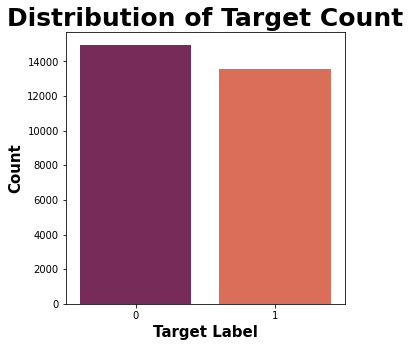

In [63]:
## Visualization of headlines count based on target values 
plt.figure(figsize=(5,5))
## palette codes : rocket, magma, viridis, cubehelix, seagreen, Blues, YlOrBr
sns.countplot(headlines.is_sarcastic, palette='rocket')
plt.title('Distribution of Target Count', size=25, weight='bold')
plt.xlabel('Target Label', size=15, weight='bold')
plt.ylabel('Count', size=15, weight='bold')
plt.show()

## Text Preprocessing

In [64]:
## Getting list stop words 
all_stopwords = []
stopwords_nltk = list(stopwords.words('english'))
sp = spacy.load('en_core_web_sm')
stopwords_spacy = list(sp.Defaults.stop_words)
stopwords_gensim = list(gensim.parsing.preprocessing.STOPWORDS)
all_stopwords.extend(stopwords_nltk)
all_stopwords.extend(stopwords_spacy)
all_stopwords.extend(stopwords_gensim)

all_stopwords = list(set(all_stopwords))

## Define function to clean headline text
def headline_cleaning(headline):
    headline = headline.lower()
    
    ## removing numbers
    number_pattern = '\d+'
    headline = re.sub(pattern=number_pattern, repl=" ", string=headline)
    
    ## Removing punctuation
    headline = headline.translate(str.maketrans('', '', punctuation))
    
    ## removing stopwords
    headline = ' '.join(word for word in headline.split() if word not in all_stopwords)
    
    ## Removing Single Character
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    headline = re.sub(pattern = single_char_pattern, repl=" ", string=headline)
    
    ## Removing Extra Spaces y
    
    space_pattern = r'\s+'
    headline = re.sub(pattern=space_pattern, repl=" ", string=headline)
    
    return headline

## Applying text preprocessing steps on headline text
headlines.headline = headlines.headline.apply(headline_cleaning)

Max length of headline text :- 101


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


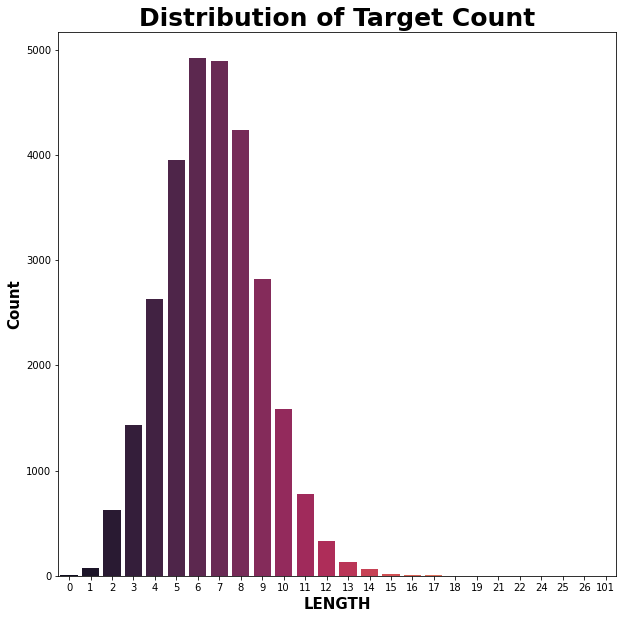

In [65]:
## Find total number of words 
corpus = []
for text in headlines['headline']:
    words = [word.lower() for word in word_tokenize(text)] 
    corpus.append(words)

## Find max length of headline 
headline_length = [len(headline) for headline in corpus]
print(f"Max length of headline text :- {max(headline_length)}")

## Creating dataframe with headline length 
headline_lenght_df = pd.DataFrame({'headline_length':headline_length})

## Visualization of headlines count based on target values 
plt.figure(figsize=(10,10))
## palette codes : rocket, magma, viridis, cubehelix, seagreen, Blues, YlOrBr
sns.countplot(headline_lenght_df.headline_length, palette='rocket')
plt.title('Distribution of Target Count', size=25, weight='bold')
plt.xlabel('LENGTH', size=15, weight='bold')
plt.ylabel('Count', size=15, weight='bold')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


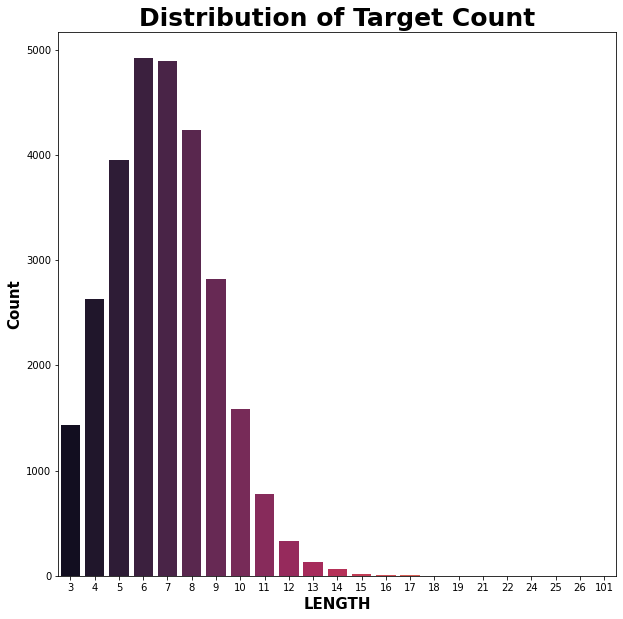

In [66]:
sample_data = headlines.copy()
sample_data['length'] = headline_length
sample_data = sample_data[sample_data['length'] > 2]
headlines = sample_data[['is_sarcastic', 'headline']]

## Visualization of headlines count based on target values 
plt.figure(figsize=(10,10))
## palette codes : rocket, magma, viridis, cubehelix, seagreen, Blues, YlOrBr
sns.countplot(sample_data.length, palette='rocket')
plt.title('Distribution of Target Count', size=25, weight='bold')
plt.xlabel('LENGTH', size=15, weight='bold')
plt.ylabel('Count', size=15, weight='bold')
plt.show()

In [67]:
## Define headline and target variables 
X = headlines.headline.values
Y = headlines.is_sarcastic.values

## Split Entire dataset to train and test sets
X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=45)

print(f"Size of the Train data :- {len(X_train)}")
print(f"Size of the Test data :- {len(X_test)}")

Size of the Train data :- 22240
Size of the Test data :- 5561


## Tokenization step

In [68]:
## Define maximum sequence length
MAX_SEQ_LENGTH = 25


## define tokenizer object 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

## create same length of headlines for train and test datasets
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LENGTH, truncating='post', padding='post')

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=MAX_SEQ_LENGTH, truncating='post', padding='post')

## Checking unique words
word_index = tokenizer.word_index
print(f"Number of unique words: {len(word_index) + 1}")

Number of unique words: 25459


## Wordembedding 


In [69]:
## download word embedding glove 
!wget http://nlp.stanford.edu/data/glove.6B.zip

## Unzip glove word embedding file 
!unzip /content/glove.6B.zip -d "Glove"

--2023-03-07 08:38:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-03-07 08:38:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-07 08:38:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [78]:
## Creating dictionary with glove words & vector values
glove_embedding = {}

with open('/content/Glove/glove.6B.100d.txt') as glove_file:
  for line in glove_file:
    values = line.split()
    word = values[0]
    word_vector = np.asarray(values[1:], 'float32')
    glove_embedding[word] = word_vector

glove_file.close()

## Define global variables 
EMBED_DIM = 100
TOTAL_NUM_WORDS = len(word_index) + 1
MAX_SEQ_LENGTH = 25

## Creating a embedding matrix for headline words using glove wordembedding matrix
embedding_matrix = np.zeros((TOTAL_NUM_WORDS, EMBED_DIM))

for i, word in tokenizer.index_word.items():
  if i < TOTAL_NUM_WORDS:
    vector = glove_embedding.get(word)
    if vector is not None:
      embedding_matrix[i] = vector

## Build Vanilla LSTM

In [71]:
EMBED_DIM = 100
TOTAL_NUM_WORDS = len(word_index) + 1
MAX_SEQ_LENGTH = 25

vanilla_lstm_model = Sequential()
vanilla_lstm_model.add(Embedding(input_dim=TOTAL_NUM_WORDS, 
                                 output_dim = EMBED_DIM,
                                 embeddings_initializer = Constant(embedding_matrix),
                                 input_length = MAX_SEQ_LENGTH,
                                 trainable=False))
vanilla_lstm_model.add(LSTM(100, dropout=0.3))
vanilla_lstm_model.add(Dense(1, activation='sigmoid'))

## Adding loss , optimizer and metrics to model
vanilla_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [72]:
vanilla_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 100)           2545900   
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,626,401
Trainable params: 80,501
Non-trainable params: 2,545,900
_________________________________________________________________


In [73]:
## Train the model
history = vanilla_lstm_model.fit(X_train, 
                                 Y_train, 
                                 epochs=30, 
                                 batch_size=256, 
                                 validation_data=(X_test, y_test))

Epoch 1/30
87/87 [==============================] - 17s 155ms/step - loss: 0.6107 - accuracy: 0.6591 - val_loss: 0.5570 - val_accuracy: 0.7094
Epoch 2/30
87/87 [==============================] - 13s 148ms/step - loss: 0.5432 - accuracy: 0.7249 - val_loss: 0.5184 - val_accuracy: 0.7387
Epoch 3/30
87/87 [==============================] - 13s 155ms/step - loss: 0.5043 - accuracy: 0.7540 - val_loss: 0.4833 - val_accuracy: 0.7605
Epoch 4/30
87/87 [==============================] - 12s 136ms/step - loss: 0.4791 - accuracy: 0.7704 - val_loss: 0.4644 - val_accuracy: 0.7736
Epoch 5/30
87/87 [==============================] - 11s 131ms/step - loss: 0.4611 - accuracy: 0.7790 - val_loss: 0.4638 - val_accuracy: 0.7770
Epoch 6/30
87/87 [==============================] - 11s 123ms/step - loss: 0.4497 - accuracy: 0.7870 - val_loss: 0.4594 - val_accuracy: 0.7770
Epoch 7/30
87/87 [==============================] - 12s 138ms/step - loss: 0.4308 - accuracy: 0.7993 - val_loss: 0.4417 - val_accuracy: 0.7858

<ipython-input-74-b166e350bd5f>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, history.history['loss'], 'b', label='Training Loss', color='red')


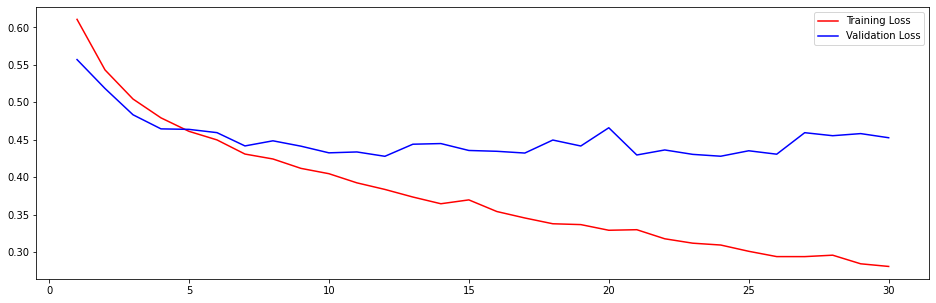

In [74]:
plt.figure(figsize=(16,5))
epochs = range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['loss'], 'b', label='Training Loss', color='red')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation Loss')
plt.legend()
plt.show()

<ipython-input-75-f02d2ebc0bd6>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, history.history['accuracy'], 'b', label='Training Accuracy', color='red')


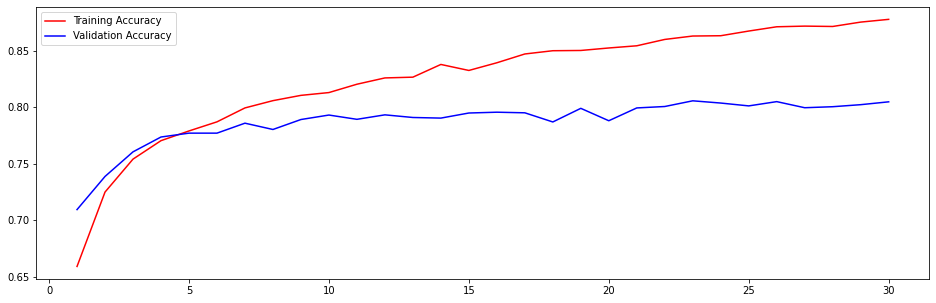

In [75]:
plt.figure(figsize=(16,5))
epochs = range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['accuracy'], 'b', label='Training Accuracy', color='red')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.legend()
plt.show()

In [76]:
## Evaluatiing model performation
y_predict = []
for i in vanilla_lstm_model.predict(X_test):
  if i > 0.5:
    y_predict.append(1)
  else:
    y_predict.append(0)


print(classification_report(y_test, y_predict))

174/174 [==============================] - 3s 13ms/step
              precision    recall  f1-score   support

           0       0.79      0.84      0.82      2861
           1       0.82      0.76      0.79      2700

    accuracy                           0.80      5561
   macro avg       0.81      0.80      0.80      5561
weighted avg       0.81      0.80      0.80      5561



In [77]:
## test with sample headline text 
sample_headline = ['thirtysomething scientists unveil doomsday clock of hair loss']

sample_headline_df = pd.DataFrame({'headline' :sample_headline})

sample_headline_df.headline = sample_headline_df.headline.apply(headline_cleaning)

sample_headline_df = tokenizer.texts_to_sequences(sample_headline_df)

sample_headline_df = pad_sequences(sample_headline_df, maxlen=MAX_SEQ_LENGTH, truncating='post', padding='post')

for i in vanilla_lstm_model.predict(sample_headline_df):
  if i > 0.5:
    print(f"Headline is a Sarcasm")
  else:
    print(f"Headline is not a Sarcasm")

1/1 [==============================] - 0s 27ms/step
Headline is a Sarcasm
